In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

#SMOTE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter
#Evaluation
from sklearn import metrics
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


# **Techniques to handle imbalanced dataset**
In this notebook, Techniques to handle imbalanced dataset is discussed. As example Logistic regression is applied on Credit card faulty transaction prediction.

Imbalanced dataset is a type of dataset where the distribution of labels across the dataset is not balanced i.e. the distribution is biased or skewed.Distribution in dataset can have slight imbalance or high imbalance. It is very uncommon in any practical applications to have perfectly equal distribution, though most of the time the distribution is slightly skewed towards one class ie. majority class.

In such scenarios, distribution is highly skewed to the extent that there can be one data point of minority class for hundreds, thousands or millions of data point of majority class. 
For example: Credit card fraud transaction - In Thousands of transaction only a very few can be faulty.

In [2]:
datasetPath = "/kaggle/input/creditcardfraud/creditcard.csv"
data = pd.read_csv(datasetPath)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As many times public dataset is more memory consuming than it needs to. Below is the script to reduce memory consumption of numeric values in a dataset

In [4]:
def reduce_mem_usage(df:pd.DataFrame)->pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        name =df[col].dtype.name 
        
        if col_type != object and col_type.name != 'category':
        #if name != "category":    
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
originalDataset = data.copy()
data = reduce_mem_usage(data)

Memory usage of dataframe is 67.36 MB


100%|██████████| 31/31 [00:00<00:00, 68.99it/s]

Memory usage after optimization is: 17.11 MB
Decreased by 74.6%


From above, we could see memory usage reduced by ~75% without losing data.

,Class,Value Count,Percentage
0,0,284315,0.998273
1,1,492,0.001727


<AxesSubplot:xlabel='Class'>

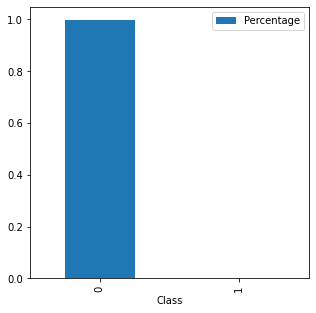

In [6]:
def val_count_df(df, column_name, sort=True):
    value_count = df[column_name].value_counts(sort=sort).reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(sort=sort,normalize=True)
    value_count = value_count.reset_index()
    value_count = value_count.style.format({'Percentage': "{:.2%}"})
    return value_count.data

target_count = val_count_df(data, "Class")
display(target_count)
target_count.set_index("Class").plot.bar(y="Percentage", figsize=(5,5), legend='Percentage')

In the given dataset - 99.9% of transactions are genuine and <0.1% of transactions are faulty. There it is crucial to classify the faulty as faulty. Because it is more dangerous to classify a Faulty transaction as genuine transaction.

In [7]:
def exploreDataset(df):
    df_copy = df.copy()
    print("The dataset contains {} rows with {} N/A values".format(df_copy.shape[0], df_copy.isna().sum()))
    print("Number of rows:", df_copy.shape[0], "Number of Cols:", df_copy.shape[1])
    numericFeatures = df_copy.select_dtypes(include = np.number).columns
    print("Numeric Features from dataset are :",numericFeatures)
    categoricalFeatures = df_copy.select_dtypes(include = object).columns
    print("Categorial Features from dataset are :",categoricalFeatures)
    
exploreDataset(data)

The dataset contains 284807 rows with Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64 N/A values
Number of rows: 284807 Number of Cols: 31
Numeric Features from dataset are : Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Categorial Features from dataset are : Index([], dtype='object')


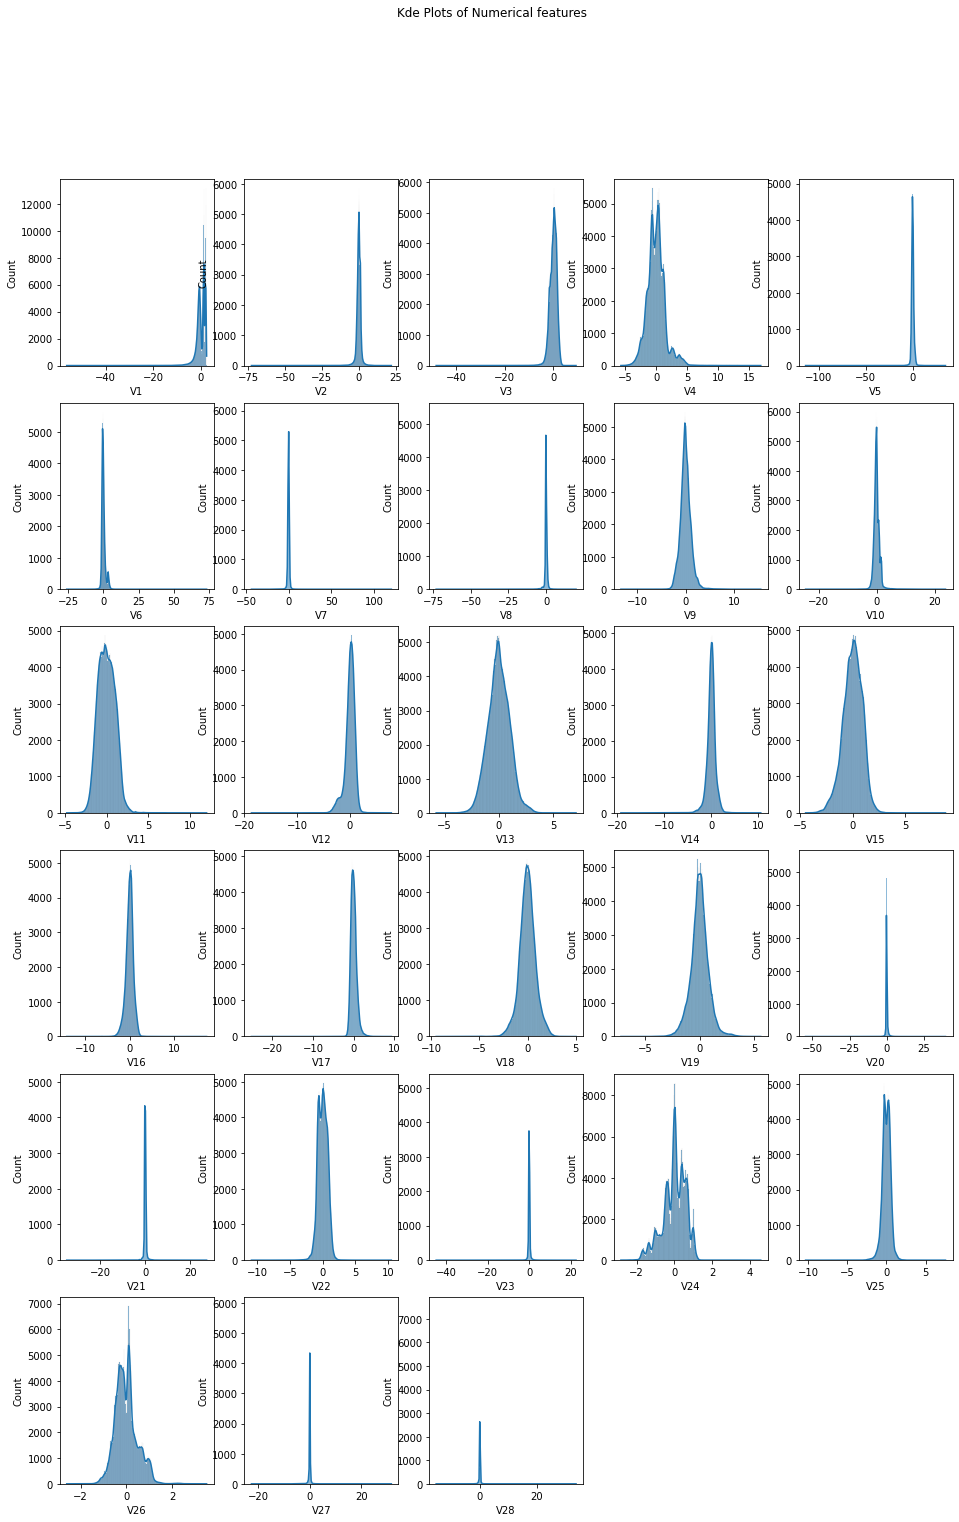

In [8]:
import seaborn as sns
plt.figure(figsize=(16,24))
numRange= [i for i in range(1,29)]
for i in numRange:
    plt.subplot(6,5,i,aspect='auto')
    param = 'V'+str(i)
    sns.histplot(data=data,x=param, kde=True)
plt.suptitle('Kde Plots of Numerical features')
plt.show()

In [9]:
def drawCorrelationMatrix(df):
    
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    plt.figure(figsize=(16,12))
    plt.title("Correlation heatmap between all parameters")
    fig = sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.1f', square=True, cmap=cmap)
    
def getRedundantPairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def getTopAbsCorrelations(df, n=5,method = 'pearson'):
#   ''' Get top 5 most correlated features in the given dataset. Method can be 'pearson', 'spearman', 'kendall' ''''
    au_corr = df.corr(method = method).abs().unstack()
    labels_to_drop = getRedundantPairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print("Top {} Correlated features in given dataset".format(n))
    return au_corr[0:n]

Top 5 Correlated features in given dataset


V2    Amount    0.531405
Time  V3        0.419616
V7    Amount    0.397302
V5    Amount    0.386358
V20   Amount    0.339399
dtype: float64

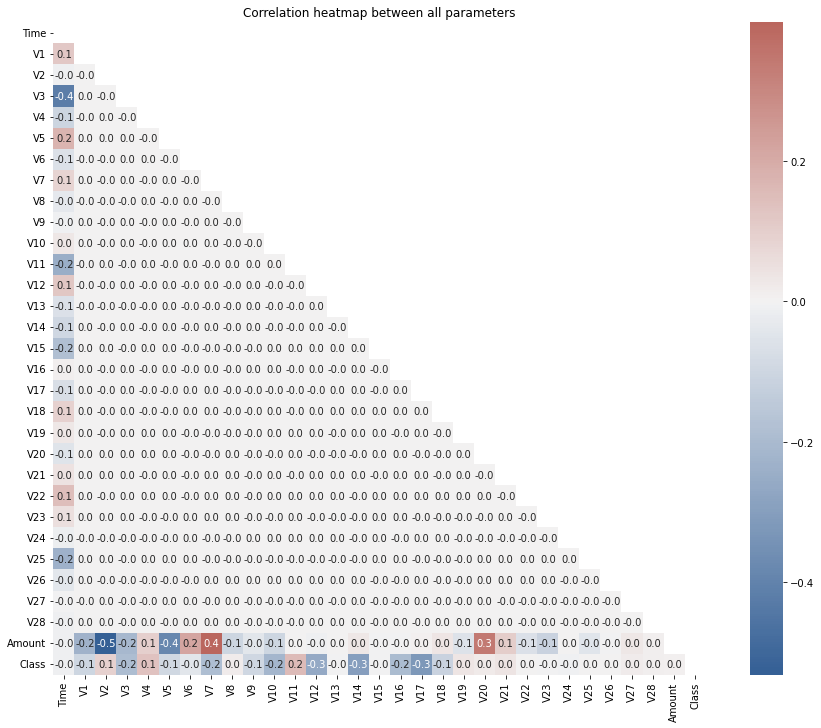

In [10]:
drawCorrelationMatrix(data)
getTopAbsCorrelations(data)

In [11]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
# split dataset into x,y
x = data.drop('Class',axis=1)
y = data['Class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

In [12]:
def cfMatrix(df):
    ax = sns.heatmap(df, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

Confusion Matrix: 
[[85291    16]
 [   60    76]]
Accuracy Score: 0.9991105181231933
Area Under Curve: 0.7793179857662877
Recall score: 0.5588235294117647


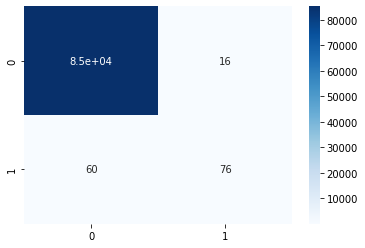

In [13]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None,solver='lbfgs', max_iter=1000)
# fit it
lg1.fit(X_train,y_train)
# test
y_pred = lg1.predict(X_test)
# performance
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

# **Weighted Logistic regression** - 
In our dataset, label distribution is 1:99 so we can specify weights as inverse of label distribution. For majority class, will use weight of 1 and for minority class, will use weight of 99. 

Confusion Matrix: 

[[85306     1]
 [  119    17]]


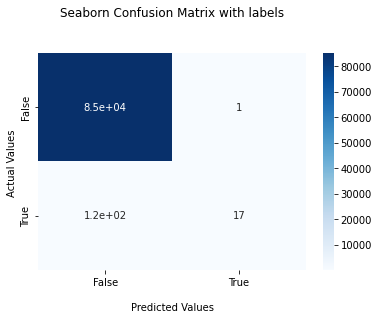

Accuracy Score: 0.9985955549313578
Area Under Curve: 0.5624941388162754
Recall score: 0.125


In [14]:
# define class weights
w = {0:99, 1:1}
# define model
lg2 = LogisticRegression(random_state=13, class_weight=w,max_iter=1000)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred = lg2.predict(X_test)
# performance
df = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n')
print(df)
cfMatrix(df)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')

print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

**Hyperpameter tuning for choosing optimised weights by Gridsearch/halvingGridSearch**

In [15]:
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}]
hyperparam_grid = {"class_weight": w }

# define model
lg3 = LogisticRegression(random_state=13,max_iter = 2000)
# define evaluation procedure
halving_cv = HalvingGridSearchCV(
    lg3, hyperparam_grid, scoring="roc_auc", n_jobs=-1, min_resources="exhaust", factor=3
)
# grid = RandomizedSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
halving_cv.fit(x,y)
print(f'Best score: {halving_cv.best_score_} with param: {halving_cv.best_params_}')

Best score: 0.8693355765666171 with param: {'class_weight': {0: 1000, 1: 100}}


Confusion Matrix: 

[[85298     9]
 [   98    38]]


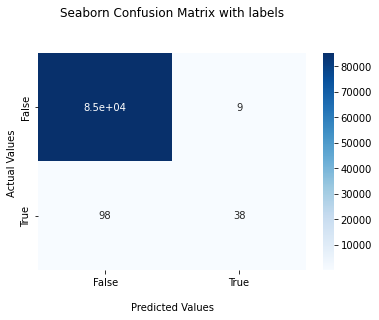

Accuracy Score: 0.9987477031471274
Area Under Curve: 0.6396531316994191
Recall score: 0.27941176470588236


In [16]:
# Best score: 0.8621391048982661 with param: {'class_weight': {0: 150, 1: 1.0}}
lg3 = LogisticRegression(random_state=13, class_weight={0: 1000, 1: 100},max_iter = 1000)
# fit it
lg3.fit(X_train,y_train)
# test
y_pred = lg3.predict(X_test)
# performance
df = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n')
print(df)
cfMatrix(df)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

In [17]:
# import warnings
# warnings.filterwarnings("ignore")
# w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
#      {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
#      {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}]
# crange = np.arange(0.5, 20.0, 0.5)
# hyperparam_grid = {"class_weight": w
#                    ,"penalty": ["l1", "l2"]
#                    ,"C": crange
#                    ,"fit_intercept": [True, False]  }

# logistic model classifier
# lg4 = LogisticRegression(random_state=13, max_iter=20000)
# # define evaluation procedure
# grid = HalvingGridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
# grid.fit(x,y)
# print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

In [18]:
lg4 = LogisticRegression(random_state=13,C=13.0,fit_intercept=True, penalty='l2',class_weight={0: 1, 1: 100} )
# fit it
lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.9901688845195042
Confusion Matrix: 
[[84488   819]
 [   21   115]]
Area Under Curve: 0.9179938081765583
Recall score: 0.8455882352941176


# **Resampling:**

**Under sampling of the majority class:** This technique involves removing random records from the majority class, which can cause loss of information. This could lead to underfitting and poor generalization to the test set.

**Oversampling of the minority class:** Adding more examples from the minority class. The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting.



In [19]:
cols = X_train.columns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

In [20]:
train_data=pd.concat([X_train,y_train],axis=1)

Response_Zero=train_data[train_data.Class==0]
Response_One=train_data[train_data.Class==1]

In [21]:
#For Sampling
from sklearn.utils import resample
upsampled_One = resample(Response_One,
                          replace=True, # sample with replacement
                          n_samples=len(Response_Zero), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([Response_Zero, upsampled_One])
upsampled.dropna(inplace = True)

In [22]:
upsampled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.946137,-0.418953,-0.144901,1.366011,-1.489894,-0.019569,0.189726,0.230395,-0.339447,0.026265,...,0.264063,1.569952,-0.696082,-1.251868,0.230812,-0.395126,-0.422691,-1.118336,-0.152386,0.0
2,-0.730359,0.596459,0.066609,0.077695,0.680884,-0.148946,-0.356501,0.041765,0.007279,-0.037407,...,0.079241,0.061813,-0.259808,-0.044380,1.233826,-0.671103,-0.012676,0.027275,-0.218768,0.0
3,-0.258435,0.641821,0.132911,0.332394,0.442754,-0.368944,-0.748074,0.034111,-0.153545,0.089714,...,-0.352148,-1.069081,0.221368,0.602788,0.394077,0.197805,-0.077137,0.056845,-0.337920,0.0
7,0.916732,0.977300,0.040999,-1.373975,0.040263,1.069574,0.890973,-0.013267,0.245998,0.269093,...,-0.304468,-0.555880,0.443916,-1.735446,-0.407959,-1.050033,0.124170,-0.119559,-0.312308,0.0
8,1.237188,1.038116,-0.028139,-1.289559,0.236202,0.465326,-0.593053,0.480989,-0.333596,0.443252,...,0.003738,0.223513,-0.022063,0.859462,0.828123,-0.507187,-0.107866,-0.163834,-0.174763,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52521,-0.523762,0.548604,0.398049,0.837603,2.806107,-0.277146,-0.068489,-0.003541,0.038510,-0.777193,...,-0.364686,-1.026679,0.224897,1.076711,0.562027,-0.425987,0.011657,0.103389,-0.306902,1.0
10484,-1.119421,0.456385,-0.242669,0.699058,0.916943,-0.444563,0.643818,-0.464265,0.290583,0.459690,...,0.081469,0.233777,-0.191377,-0.462533,0.629956,-0.773803,0.165192,0.121636,0.083763,1.0
15781,-0.494029,-1.080442,0.689499,0.614319,-0.645396,-1.019619,-0.004855,-0.557382,0.924041,0.705823,...,0.048059,-0.060430,0.338818,0.225420,-1.381223,1.333836,-2.605959,-0.950870,-0.213642,1.0
18773,-0.578217,-0.151641,0.647991,0.549235,-0.232983,0.481154,0.010004,0.477859,0.115474,-0.544389,...,-0.388774,-1.074465,-0.284710,-1.457047,-0.057917,0.261045,0.591373,0.232694,-0.343163,1.0


,Class,Value Count,Percentage
0,1.0,154623,0.526299
1,0.0,139170,0.473701


<AxesSubplot:xlabel='Class'>

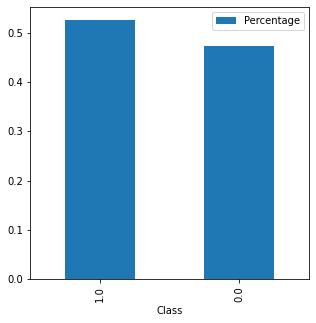

In [23]:
target_count = val_count_df(upsampled, "Class")
display(target_count)
target_count.set_index("Class").plot.bar(y="Percentage", figsize=(5,5), legend='Percentage')

In [24]:
x = upsampled.drop('Class',axis=1)
y = upsampled['Class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

lg4 = LogisticRegression(random_state=13, max_iter = 1000)
# fit it

lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.5550727268601511
Confusion Matrix: 
[[14889 26771]
 [12444 34034]]
Area Under Curve: 0.5448268035980124
Recall score: 0.7322604242867593


# **SMOTE (Synthetic Minority Oversampling Technique)**

SMOTE is an algorithm that performs data augmentation by creating synthetic data points based on the original data points. SMOTE can be seen as an advanced version of oversampling, or as a specific algorithm for data augmentation. The advantage of SMOTE is that you are not generating duplicates, but rather creating synthetic data points that are slightly different from the original data points.
<!-- 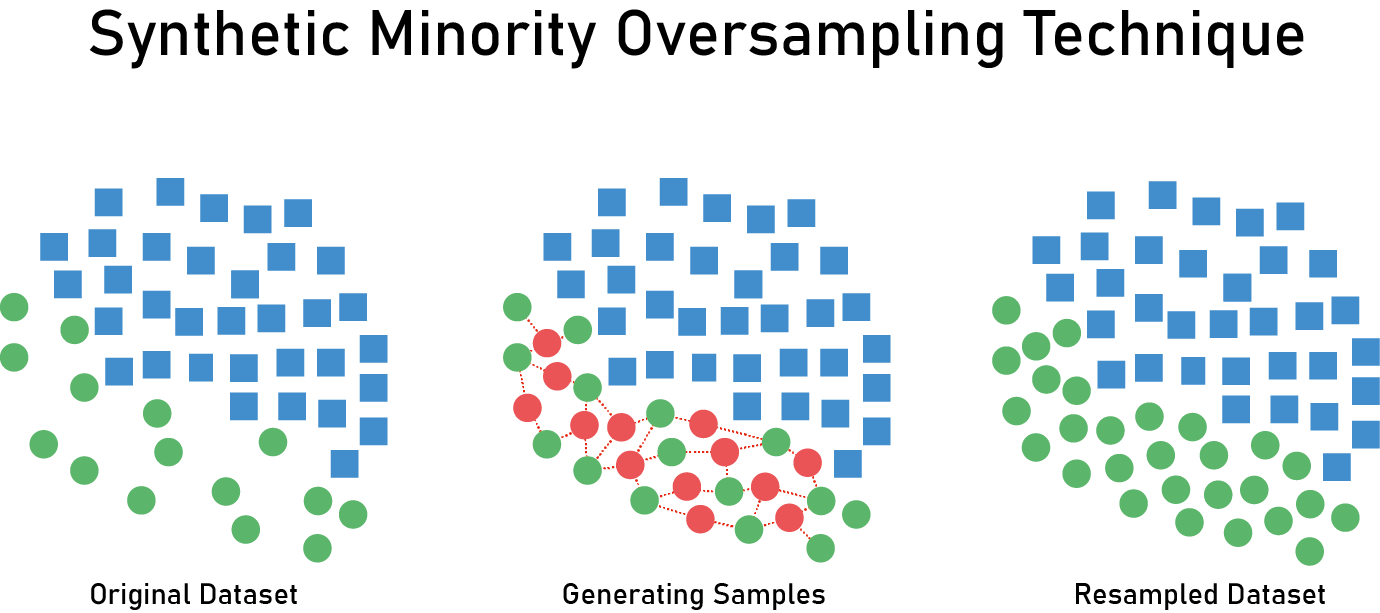 -->
<div>
    <img src=attachment:0901243a-19d9-4d64-bdab-88a00db62c97.png width="600">
</div>
<!-- 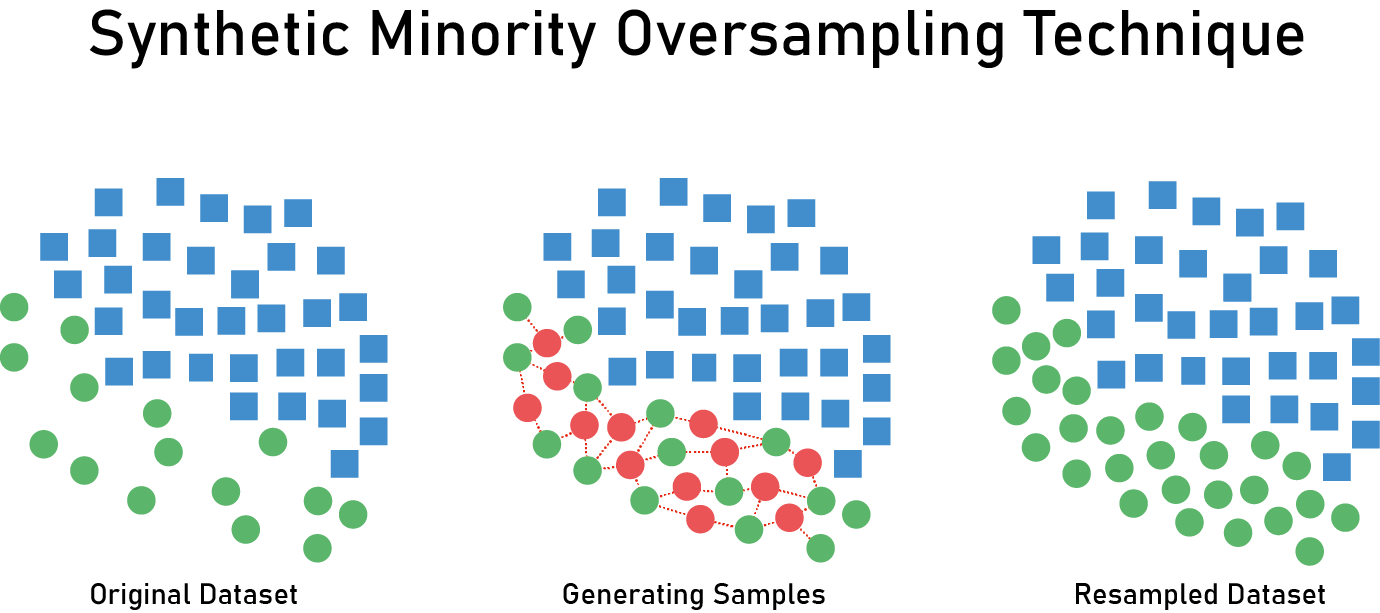 -->

In [25]:
lg5 = LogisticRegression(random_state=13,class_weight={0:99, 1: 1})
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), lg5)

In [26]:
x = data.drop('Class',axis=1)
y = data['Class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)
smote_model = smote_pipeline.fit(X_train, y_train)

In [27]:
smote_prediction = smote_model.predict(X_test)

In [28]:
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_resample(x, y)

print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


In [29]:
print(f'Accuracy Score: {accuracy_score(y_test,smote_prediction)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, smote_prediction)}')
print(f'Area Under Curve: {roc_auc_score(y_test, smote_prediction)}') # 0.5
print(f'Recall score: {recall_score(y_test,smote_prediction)}')

Accuracy Score: 0.9988647402361809
Confusion Matrix: 
[[85242    65]
 [   32   104]]
Area Under Curve: 0.8819719642343674
Recall score: 0.7647058823529411


References:

https://www.kaggle.com/code/sandhyakrishnan02/imbalance-insurance-data-analysis

https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b

https://medium.com/analytics-vidhya/bank-data-smote-b5cb01a5e0a2